# Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords', quiet=True)

True

# Предварительная обработка

In [2]:
df = pd.read_json('train.json')
df

,text,id,sentiment
0,Досудебное расследование по факту покупки ЕНПФ...,1945,negative
1,Медики рассказали о состоянии пострадавшего му...,1957,negative
2,"Прошел почти год, как железнодорожным оператор...",1969,negative
3,По итогам 12 месяцев 2016 года на территории р...,1973,negative
4,Астана. 21 ноября. Kazakhstan Today - Агентств...,1975,negative
...,...,...,...
8258,"Как мы писали еще весной, для увеличения сбыта...",10312,positive
8259,Но молодой министр национальной экономики Биши...,10313,negative
8260,\n \nВ ЕНПФ назначен новый председатель правле...,10314,neutral
8261,В Алматы у отделения банка произошло нападение...,10315,negative


In [3]:
del df['id']

In [4]:
df

,text,sentiment
0,Досудебное расследование по факту покупки ЕНПФ...,negative
1,Медики рассказали о состоянии пострадавшего му...,negative
2,"Прошел почти год, как железнодорожным оператор...",negative
3,По итогам 12 месяцев 2016 года на территории р...,negative
4,Астана. 21 ноября. Kazakhstan Today - Агентств...,negative
...,...,...
8258,"Как мы писали еще весной, для увеличения сбыта...",positive
8259,Но молодой министр национальной экономики Биши...,negative
8260,\n \nВ ЕНПФ назначен новый председатель правле...,neutral
8261,В Алматы у отделения банка произошло нападение...,negative


In [5]:
df.sentiment.value_counts()

sentiment
neutral     4034
positive    2795
negative    1434
Name: count, dtype: int64

In [6]:
# Функция очистки текста
def clean_text(text):
    # Приводим текст к нижнему регистру
    text = text.lower()
    
    # Удаляем ссылки
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Удаляем специальные символы и числа
    text = re.sub(r'[^a-zа-яё\s]', '', text)
    
    # Удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Удаялем стоп слова
    stop_words = set(stopwords.words('russian'))
    text = ' '.join(word for word in text.split() if word not in stop_words)

    return text


In [7]:
df['text']= df['text'].apply(clean_text)
df

,text,sentiment
0,досудебное расследование факту покупки енпф па...,negative
1,медики рассказали состоянии пострадавшего мужч...,negative
2,прошел год железнодорожным операторам запретил...,negative
3,итогам месяцев года территории республики выпу...,negative
4,астана ноября kazakhstan today агентство рк де...,negative
...,...,...
8258,писали весной увеличения сбыта также избегания...,positive
8259,молодой министр национальной экономики бишимба...,negative
8260,енпф назначен новый председатель правления еди...,neutral
8261,алматы отделения банка произошло нападение стр...,negative


# Разработка моделей

In [8]:
# Функция bag of words
def bag_of_words(texts):
    vectorizer = CountVectorizer()
    return vectorizer.fit_transform(texts)

In [9]:
#Функция TF-IDF
def tf_idf(texts):
    vectorizer = TfidfVectorizer()
    return vectorizer.fit_transform(texts)

In [10]:
X = df['text']
y = df['sentiment'].map({'negative' : 0, 'neutral' : 1,'positive' : 2})

In [11]:
X_bag = bag_of_words(X)
X_tf = tf_idf(X)
X_train_bag, X_test_bag, y_train, y_test = train_test_split(X_bag, y, test_size=0.2, random_state=42)
X_train_tf, X_test_tf, y_train, y_test = train_test_split(X_tf, y, test_size=0.2, random_state=42)

In [12]:
# Функция оценки моделей
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')

In [22]:
#Гипер параметры лог регрессии
params_log = { 'C': [0.01, 0.1,], 'solver': ['liblinear', 'saga'], 'penalty': ['l1', 'l2'], 'max_iter': [1500, 2000]}
#Гипер паарметры байеса
params_ba = {'alpha' : [0.1, 0.5, 1]}
#Гипер параметры дерева
params_tree = { 'criterion': ['gini', 'entropy'], 'max_depth': [10, 20], 'max_features': [0.1, 0.5, 1]}

In [14]:
# Логистическая регрессия 
def logistic_regression(X_train, X_test, y_train, y_test):
    best_f1 = 0
    best_params = None
    best_y_pred = 0
    
    # Перебор гиперпараметров
    for C in params_log['C']:
        for solver in params_log['solver']:
            for penalty in params_log['penalty']:
                for max_iter in params_log['max_iter']:  
                    model = LogisticRegression(C=C, solver=solver, penalty=penalty, max_iter=max_iter)
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    
                    f1 = f1_score(y_test, y_pred, average='weighted')
                    # Оценка по ф1
                    if f1 > best_f1:
                        best_f1 = f1
                        best_params = {'C': C, 'solver': solver, 'penalty': penalty, 'max_iter': max_iter}
                        best_y_pred = y_pred

    print("\nBest parameters found: ", best_params)
    evaluate_model(y_test, best_y_pred)
    return confusion_matrix(y_test, best_y_pred)

In [15]:
# байесовский классификатор
def naive_bayes(X_train, X_test, y_train, y_test):
    best_f1 = 0
    best_params = None
    best_y_pred = 0
    
    #Перебор гиперпараметров
    for  alpha in params_ba['alpha']:  
        model = MultinomialNB(alpha = alpha)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        f1 = f1_score(y_test, y_pred, average='weighted')
        # Оценка по ф1
        if f1 > best_f1:
            best_f1 = f1
            best_params = {'alpha' : alpha}
            best_y_pred = y_pred
    
    print("\nBest parameters found: ", best_params)
    evaluate_model(y_test, best_y_pred)
    return confusion_matrix(y_test, best_y_pred)

In [26]:
# Деревья
def decision_tree(X_train, X_test, y_train, y_test):
    best_f1 = 0
    best_params = None
    best_y_pred = 0
    
    #Перебор гиперпараметров
    for criterion in params_tree['criterion']:
        for max_depth in params_tree['max_depth']:
            for max_features in params_tree['max_features']:
                model = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, max_features = max_features)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                f1 = f1_score(y_test, y_pred, average='weighted')
                # Оценка по ф1
                if f1 > best_f1:
                    best_f1 = f1
                    best_params = {'criterion' : criterion, 'max_depth' : max_depth, 'max_features' : max_features}
                    best_y_pred = y_pred
    
    print("\nBest parameters found: ", best_params)
    evaluate_model(y_test, best_y_pred)
    return confusion_matrix(y_test, best_y_pred)

# Оценка моделей

In [17]:
# Оценка логистической регрессия для BOW
cm_log_bow = logistic_regression(X_train_bag, X_test_bag, y_train, y_test)

D:\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anacond


Best parameters found:  {'C': 0.1, 'solver': 'saga', 'penalty': 'l2', 'max_iter': 2000}
Accuracy: 0.70
Precision: 0.71
Recall: 0.70
F1 Score: 0.70


D:\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [18]:
# Оценка логистической регрессия для TF-IDF
cm_log_tf = logistic_regression(X_train_tf, X_test_tf, y_train, y_test)


Best parameters found:  {'C': 0.1, 'solver': 'saga', 'penalty': 'l2', 'max_iter': 1500}
Accuracy: 0.63
Precision: 0.69
Recall: 0.63
F1 Score: 0.59


In [23]:
# Оценка Байеса для Bow
cm_ba_bow = naive_bayes(X_train_bag, X_test_bag, y_train, y_test)


Best parameters found:  {'alpha': 0.1}
Accuracy: 0.70
Precision: 0.72
Recall: 0.70
F1 Score: 0.70


In [24]:
# Оценка Байеса для TF-IDF
cm_ba_tf = naive_bayes(X_train_tf, X_test_tf, y_train, y_test)


Best parameters found:  {'alpha': 0.1}
Accuracy: 0.72
Precision: 0.72
Recall: 0.72
F1 Score: 0.72


In [27]:
# Оценка деревьев для BOW
cm_tree_bow = decision_tree(X_train_bag, X_test_bag, y_train, y_test)


Best parameters found:  {'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.5}
Accuracy: 0.58
Precision: 0.58
Recall: 0.58
F1 Score: 0.57


In [28]:
# Оценка деревьев для TF-IDF
cm_tree_tf = decision_tree(X_train_tf, X_test_tf, y_train, y_test)


Best parameters found:  {'criterion': 'gini', 'max_depth': 20, 'max_features': 0.5}
Accuracy: 0.60
Precision: 0.62
Recall: 0.60
F1 Score: 0.57


In [29]:
# Построение графика матрицы
def plot_confusion_matrix(cm, classes = ['negative', 'neutral','positive'], title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

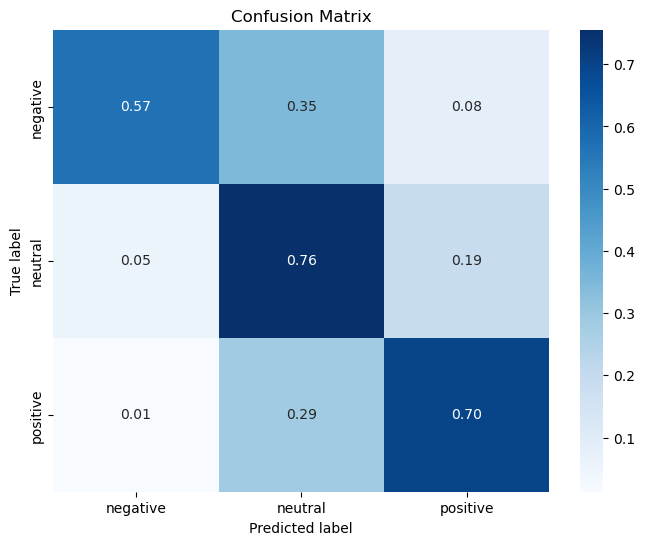

In [30]:
# Confusion matrix для логистической регресии bow
plot_confusion_matrix(cm_log_bow)

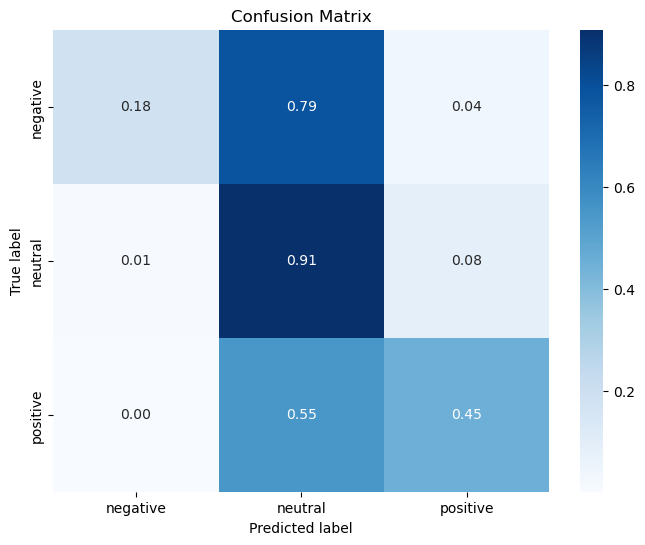

In [31]:
# Confusion matrix для логистической регресии TF-IDF
plot_confusion_matrix(cm_log_tf)

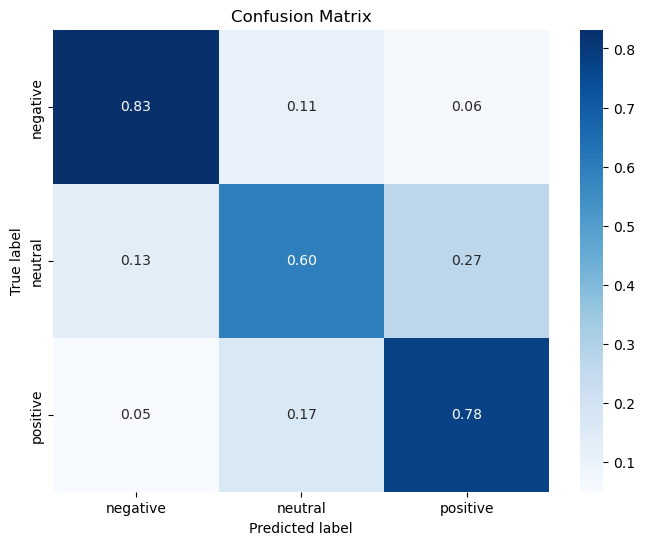

In [32]:
# Confusion matrix для байеса bow
plot_confusion_matrix(cm_ba_bow)

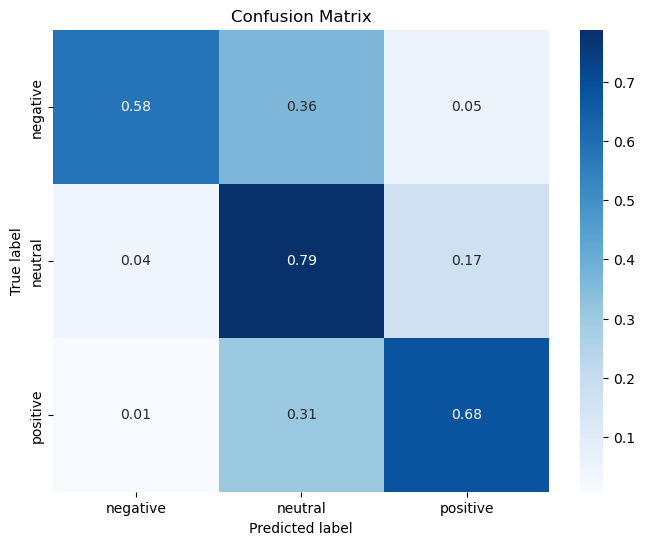

In [33]:
# Confusion matrix для байеса TF-IDF
plot_confusion_matrix(cm_ba_tf)

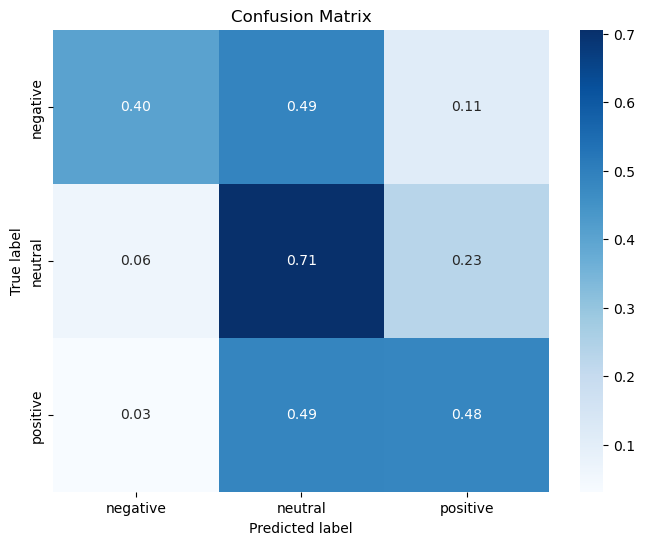

In [34]:
# Confusion matrix для дерева bow
plot_confusion_matrix(cm_tree_bow)

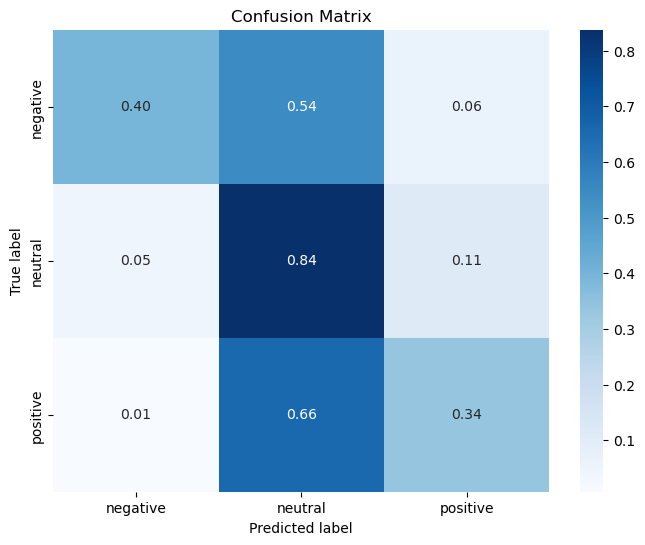

In [35]:
# Confusion matrix для дерева TF-IDF
plot_confusion_matrix(cm_tree_tf)